In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.animation import FFMpegWriter
import cv2
import src.procrustes as procrustes
import src.utils as utils
from tqdm import tqdm

In [2]:
from skeleton import skeleton
G, color_edge = skeleton()

def read_cropped_image(f):
    return cv2.imread('/data/LiftFly3D/flylimbtracker/data/flylimbtracker_data/labeled-data/cropped/img{:03d}.png'.format(f))[:,:,0]

def read_image(f):
    return cv2.imread('/data/LiftFly3D/flylimbtracker/data/frames/{:03d}.png'.format(f))[:,:,0]

# Load annotated data

In [3]:
n_frames = 100
bottom = pd.read_hdf('/data/LiftFly3D/flylimbtracker/data/flylimbtracker_data/labeled-data/cropped/CollectedData_Adam Gosztolai.h5')
bottom = bottom.reset_index()
bottom = bottom.droplevel('scorer',axis=1)
bottom = bottom.iloc[:,1:]
bottom_np = bottom.loc[:n_frames-1,(slice(None),['x','y'])].to_numpy()
points2d = np.stack((bottom_np[:,::2], bottom_np[:,1::2]), axis=2)
imgs = [read_cropped_image(t) for t in range(n_frames)]

In [4]:
points2d.shape

(100, 30, 2)

# Cropped image

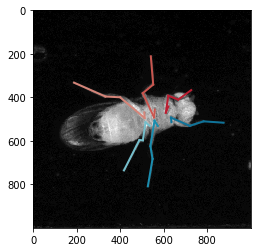

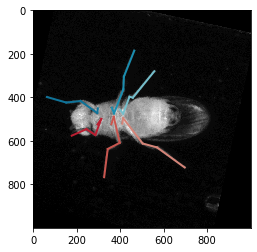

In [5]:
t = 0

angle, c, img_rot = procrustes.orientation(imgs[t], 10)

shape = [imgs[t].shape[0]//2, imgs[t].shape[1]//2]
pos_rot, angle = procrustes.center_and_align(points2d[t,:,:], np.radians(angle), shape, np.array(c) )

#skeleton
plt.figure()
plt.imshow(imgs[t], cmap='gray')
utils.plot_skeleton(G, points2d[t,:,0], points2d[t,:,1], color_edge)

#aligned
plt.figure()
plt.imshow(img_rot, cmap='gray')
utils.plot_skeleton(G, pos_rot[:,0], pos_rot[:,1], color_edge)
#plt.savefig('fly.png',dpi=300)

# Whole arena

(-0.5, 2559.5, 917.5, -0.5)

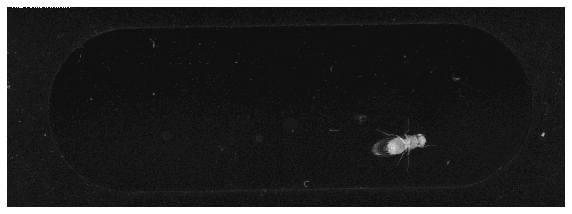

In [6]:
plt.figure(figsize=(10,5))
img = read_image(0)
plt.imshow(img*8, cmap='gray')
plt.axis('off')
#cv2.imwrite('arena.png',img*10)

Video

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

writer = FFMpegWriter(fps=10)
with writer.saving(fig, "arena.mp4", 100):
    for frame_idx in range(n_frames):
        plt.cla()

        img = read_image(frame_idx)
        plt.imshow(img*8 , cmap='gray')
        #plot_skeleton(points2d[frame_idx,:,0], points2d[frame_idx,:,1], ids, color_edge)

        plt.axis('off')
        writer.grab_frame() 

# Align frames

In [7]:
points2d_aligned = np.zeros_like(points2d)
imgs_aligned = []
for frame_idx in range(n_frames):
    shape = [imgs[frame_idx].shape[0]//2, imgs[frame_idx].shape[1]//2]
    angle, c, img_rot = procrustes.orientation(imgs[frame_idx], 10)
    pos_rot, angle = procrustes.center_and_align(points2d[frame_idx,:,:], np.radians(angle), shape, np.array(c))
        
    points2d_aligned[frame_idx,:,:] = pos_rot    
    imgs_aligned.append(img_rot)

# Make ventral video

100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


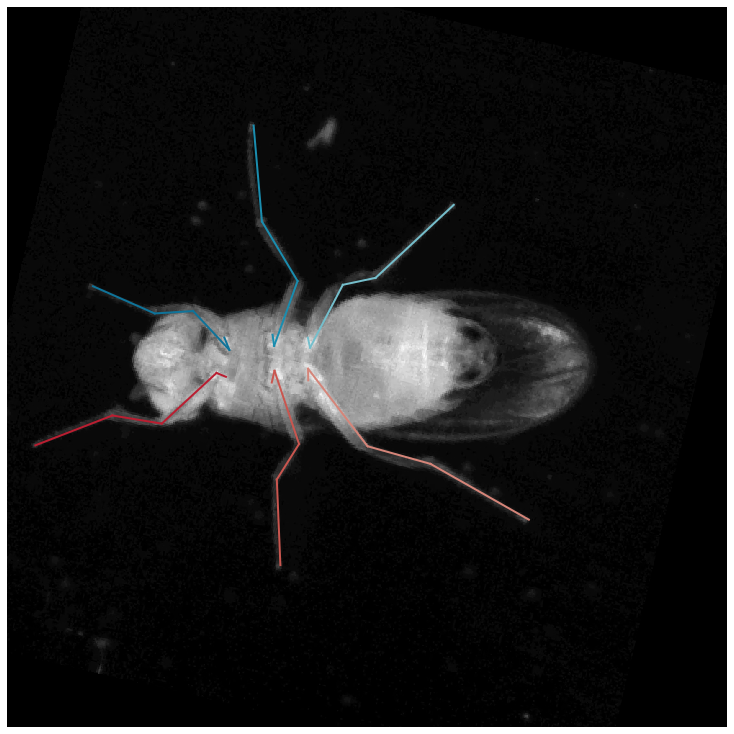

In [8]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.xlim([100,800])
plt.ylim([100,800])

writer = FFMpegWriter(fps=10)
with writer.saving(fig, "cropped.mp4", 100):
    for frame_idx in tqdm(range(0, n_frames)):
        plt.cla()

        plt.imshow(imgs_aligned[frame_idx], cmap='gray')
        x = points2d_aligned[frame_idx,:,0]
        y = points2d_aligned[frame_idx,:,1]
        utils.plot_skeleton(G, x, y, color_edge)
                
        #plt.text(120, 80, str(frame_idx), fontsize=20, color='white')

        plt.axis('off')
        writer.grab_frame() 

# Adjust to template and save

In [14]:
template_dir = '/data/LiftFly3D/flylimbtracker/network/'
body_coxas = [1,6,11,16,21,26]
prism_template = pickle.load(open(template_dir + '191125_PR_Fly1_001_prism.pkl','rb'))['points2d']
_, _, R,scale,t = procrustes.compute_similarity_transform(prism_template[0,:,:,:].mean(axis=0)[body_coxas,:], points2d_aligned[:, body_coxas,:].mean(axis=0),compute_optimal_scale=True)

points2d_rescale = np.zeros_like(points2d_aligned)
for frame_idx in range(n_frames):
    points2d_rescale[frame_idx,:,:] = scale*np.dot(points2d_aligned[frame_idx,:,:], R) + t
    
points2d_rescale[:,:15,:] = 0.9*points2d_rescale[:,:15,:]
points2d_rescale[:,15:,:] = 0.9*points2d_rescale[:,15:,:]
    
pickle.dump({"points2d": points2d_rescale}, open('/data/LiftFly3D/flylimbtracker/data/flylimbtracker_filt.pkl', 'wb'))

In [23]:
prism_template[0,:,:,:].mean(axis=0)[body_coxas,:]
#points2d[:, body_coxas,:].mean(axis=0).shape

array([[183.51384634, 196.02273484],
       [216.40559923, 196.49218908],
       [244.27758547, 193.26147261],
       [180.32746996, 226.35316526],
       [215.94516579, 222.71136454],
       [244.38675553, 225.9070697 ]])

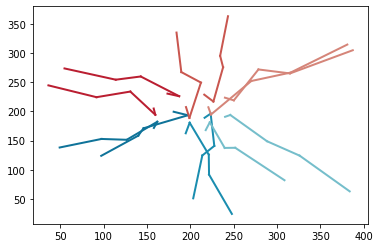

In [11]:
t = 5
utils.plot_skeleton(G, prism_template[0,t,:,0], prism_template[0,t,:,1], color_edge)
utils.plot_skeleton(G, points2d_rescale[t,:,0], points2d_rescale[t,:,1], color_edge)

# Distributions

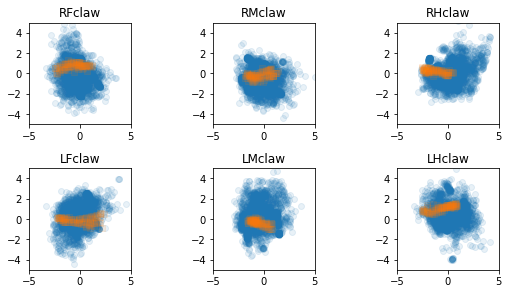

In [16]:
import torch 
tint = [0,n_frames]
times = np.arange(tint[0],tint[1])
times_prism = np.arange(4000)

prism_dir = '/data/LiftFly3D/flylimbtracker/network/'
optobot_dir = "/data/LiftFly3D/flylimbtracker/data/"

poses_optobot = torch.load(optobot_dir + 'test_2d.pth.tar')
poses_prism = torch.load(prism_dir + 'train_2d.pth.tar')

poses_optobot = np.concatenate([v for k,v in poses_optobot.items()], 0)
poses_prism = np.concatenate([v for k,v in poses_prism.items()], 0)

poses_optobot = np.stack((poses_optobot[:,::2], poses_optobot[:,1::2]), axis=2)
poses_prism = np.stack((poses_prism[:,::2], poses_prism[:,1::2]), axis=2)

fig = plt.figure(figsize=([8,8])) 

leg_tips = ['RFclaw', 'RMclaw', 'RHclaw', 'LFclaw', 'LMclaw', 'LHclaw']
joint_id = [3, 7, 11, 15, 19, 23] #legtips
for i, k in enumerate(joint_id):
    fig.add_subplot(4,3,i+1)
    plt.title(leg_tips[i])
    
    plt.plot(poses_prism[times_prism,k,0], poses_prism[times_prism,k,1],'o',alpha=0.1)  
    plt.plot(poses_optobot[times,k,0], poses_optobot[times,k,1],'s',alpha=0.1)
    plt.axis('square')
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    
plt.tight_layout()
plt.savefig('distribution.svg')